# Portfolio 2: Analysing COVID-19 Data

For the second portfolio we'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that you'll see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score, f1_score
%matplotlib inline

## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset but you can also get data on deaths and recovered cases.  

We can download a copy of the data into  project or just read it from the URL which is done below. The advantage of reading the URL is that we'll get live updates.

In [2]:
# load the live dataset, assumes a working network connection
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)

In [3]:
covid

Province/State         Country/Region        Lat       Long  1/22/20  \
0              NaN            Afghanistan  33.000000  65.000000        0   
1              NaN                Albania  41.153300  20.168300        0   
2              NaN                Algeria  28.033900   1.659600        0   
3              NaN                Andorra  42.506300   1.521800        0   
4              NaN                 Angola -11.202700  17.873900        0   
..             ...                    ...        ...        ...      ...   
261            NaN  Sao Tome and Principe   0.186360   6.613081        0   
262            NaN                  Yemen  15.552727  48.516388        0   
263            NaN                Comoros -11.645500  43.333300        0   
264            NaN             Tajikistan  38.861034  71.276093        0   
265            NaN                Lesotho -29.609988  28.233608        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  5/14/20  5/15/20  \
0          0        0        0        0        0  ...     5639     6053   
1          0        0        0        0        0  ...      898      916   
2          0        0        0        0        0  ...     6442     6629   
3          0        0        0        0        0  ...      761      761   
4          0        0        0        0        0  ...       48       48   
..       ...      ...      ...      ...      ...  ...      ...      ...   
261        0        0        0        0        0  ...      235      235   
262        0        0        0        0        0  ...       85      106   
263        0        0        0        0        0  ...       11       11   
264        0        0        0        0        0  ...      907     1118   
265        0        0        0        0        0  ...        1        1   

     5/16/20  5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  
0       6402     6664     7072     7653     8145     8676     9216     9998  
1        933      946      948      949      964      969      981      989  
2       6821     7019     7201     7377     7542     7728     7918     8113  
3        761      761      761      761      762      762      762      762  
4         48       48       50       52       52       58       60       61  
..       ...      ...      ...      ...      ...      ...      ...      ...  
261      235      235      246      251      251      251      251      251  
262      122      128      130      167      184      197      209      212  
263       11       11       11       11       34       34       78       78  
264     1322     1524     1729     1936     2140     2350     2551     2738  
265        1        1        1        1        1        1        2        2  

[266 rows x 127 columns]

## Explore the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to do we'll look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [4]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])

we can now select just the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. WE will the data for one country (spain) and plot it.  We can see the exponential rise in case numbers over time.

In [5]:
grouped.loc[['Spain']]


1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Spain                 0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  ...  5/14/20  5/15/20  5/16/20  \
Country/Region                             ...                              
Spain                 0        0        0  ...   229540   230183   230698   

                5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  
Country/Region                                                                 
Spain            230698   231606   232037   232555   233037   234824   235290  

[1 rows x 123 columns]

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  Now we will select a number of countries and plot their data on the same graph to reproduce this visualisation. Suitable countries would be those who have significant outbreaks - China, USA, Italy, Australia, Germany. 

In [6]:
df1 = grouped.loc[['Germany','Italy','Spain','China','USA','Australia']]
df1

C:\Users\rakshith\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Germany             0.0      0.0      0.0      0.0      0.0      1.0      4.0   
Italy               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Spain               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
China             548.0    643.0    920.0   1406.0   2075.0   2877.0   5509.0   
USA                 NaN      NaN      NaN      NaN      NaN      NaN      NaN   
Australia           0.0      0.0      0.0      0.0      4.0      5.0      5.0   

                1/29/20  1/30/20  1/31/20  ...   5/14/20   5/15/20   5/16/20  \
Country/Region                             ...                                 
Germany             4.0      4.0      5.0  ...  174478.0  175233.0  175752.0   
Italy               0.0      0.0      2.0  ...  223096.0  223885.0  224760.0   
Spain               0.0      0.0      0.0  ...  229540.0  230183.0  230698.0   
China            6087.0   8141.0   9802.0  ...   84029.0   84038.0   84044.0   
USA                 NaN      NaN      NaN  ...       NaN       NaN       NaN   
Australia           6.0      9.0      9.0  ...    7019.0    7035.0    7044.0   

                 5/17/20   5/18/20   5/19/20   5/20/20   5/21/20   5/22/20  \
Country/Region                                                               
Germany         176369.0  176551.0  177778.0  178473.0  179021.0  179710.0   
Italy           225435.0  225886.0  226699.0  227364.0  228006.0  228658.0   
Spain           230698.0  231606.0  232037.0  232555.0  233037.0  234824.0   
China            84054.0   84063.0   84063.0   84063.0   84063.0   84081.0   
USA                  NaN       NaN       NaN       NaN       NaN       NaN   
Australia         7054.0    7068.0    7072.0    7081.0    7095.0    7099.0   

                 5/23/20  
Country/Region            
Germany         179986.0  
Italy           229327.0  
Spain           235290.0  
China            84084.0  
USA                  NaN  
Australia         7114.0  

[6 rows x 123 columns]

In [7]:
df = df1.dropna()

In [8]:
df.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Germany             0.0      0.0      0.0      0.0      0.0      1.0      4.0   
Italy               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Spain               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
China             548.0    643.0    920.0   1406.0   2075.0   2877.0   5509.0   
Australia           0.0      0.0      0.0      0.0      4.0      5.0      5.0   

                1/29/20  1/30/20  1/31/20  ...   5/14/20   5/15/20   5/16/20  \
Country/Region                             ...                                 
Germany             4.0      4.0      5.0  ...  174478.0  175233.0  175752.0   
Italy               0.0      0.0      2.0  ...  223096.0  223885.0  224760.0   
Spain               0.0      0.0      0.0  ...  229540.0  230183.0  230698.0   
China            6087.0   8141.0   9802.0  ...   84029.0   84038.0   84044.0   
Australia           6.0      9.0      9.0  ...    7019.0    7035.0    7044.0   

                 5/17/20   5/18/20   5/19/20   5/20/20   5/21/20   5/22/20  \
Country/Region                                                               
Germany         176369.0  176551.0  177778.0  178473.0  179021.0  179710.0   
Italy           225435.0  225886.0  226699.0  227364.0  228006.0  228658.0   
Spain           230698.0  231606.0  232037.0  232555.0  233037.0  234824.0   
China            84054.0   84063.0   84063.0   84063.0   84063.0   84081.0   
Australia         7054.0    7068.0    7072.0    7081.0    7095.0    7099.0   

                 5/23/20  
Country/Region            
Germany         179986.0  
Italy           229327.0  
Spain           235290.0  
China            84084.0  
Australia         7114.0  

[5 rows x 123 columns]

In [9]:
#graph

**Challenge** A very useful visualisation shows the data for different countries aligned from the time that they have 100 confirmed cases.  To create this figure, you need to take only the part of each time series after the value is greater than or equal to 100 and then plot this starting at 0 on the x-axis.  This is a bit more involved but will allow you to explore Pandas a bit more.

In [10]:
import datetime
dti = pd.to_datetime(['3/1/20', np.datetime64('2020-03-01'),datetime.datetime(2020,3,1)])
dti

DatetimeIndex(['2020-03-01', '2020-03-01', '2020-03-01'], dtype='datetime64[ns]', freq=None)

In [11]:
df

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Germany             0.0      0.0      0.0      0.0      0.0      1.0      4.0   
Italy               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Spain               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
China             548.0    643.0    920.0   1406.0   2075.0   2877.0   5509.0   
Australia           0.0      0.0      0.0      0.0      4.0      5.0      5.0   

                1/29/20  1/30/20  1/31/20  ...   5/14/20   5/15/20   5/16/20  \
Country/Region                             ...                                 
Germany             4.0      4.0      5.0  ...  174478.0  175233.0  175752.0   
Italy               0.0      0.0      2.0  ...  223096.0  223885.0  224760.0   
Spain               0.0      0.0      0.0  ...  229540.0  230183.0  230698.0   
China            6087.0   8141.0   9802.0  ...   84029.0   84038.0   84044.0   
Australia           6.0      9.0      9.0  ...    7019.0    7035.0    7044.0   

                 5/17/20   5/18/20   5/19/20   5/20/20   5/21/20   5/22/20  \
Country/Region                                                               
Germany         176369.0  176551.0  177778.0  178473.0  179021.0  179710.0   
Italy           225435.0  225886.0  226699.0  227364.0  228006.0  228658.0   
Spain           230698.0  231606.0  232037.0  232555.0  233037.0  234824.0   
China            84054.0   84063.0   84063.0   84063.0   84063.0   84081.0   
Australia         7054.0    7068.0    7072.0    7081.0    7095.0    7099.0   

                 5/23/20  
Country/Region            
Germany         179986.0  
Italy           229327.0  
Spain           235290.0  
China            84084.0  
Australia         7114.0  

[5 rows x 123 columns]

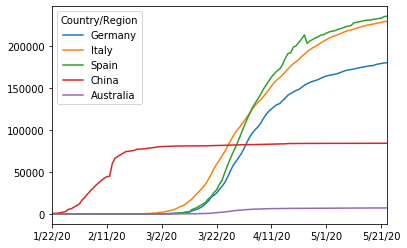

In [12]:
df.T.plot()


## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries.  It would be interesting to see whether the number of cases in China and the US was more per-capita than those in other countries and we will find which country has the highest number as a proportion of the population. (A good way to measure this is the number of cases per million people in the population. If a country has 25 cases and a population of 2.5 million they would have 10 cases per million).

To answer these questions we need population data. I'll present two possible sources of data (there are more of course) [datahub.io](https://datahub.io/JohnSnowLabs/population-figures-by-country) has data per country up to 2016 in a handy CSV format. The [United Nations Population Dynamics page](https://population.un.org/wpp/Download/Standard/CSV/) has data that predicts populations up to 2100 in CSV format.  We will Create a new plot with this data.

_Note, to use the population data we'll have to make sure that the country names match up in the different data sets. There's no magic way to do this, either you edit one of the datasets or write code to modify the data once you read it in.  The second of these is better because it makes it easy for someone else to repeat your analysis._

In [13]:
total = pd.read_csv(r'C:\Users\rakshith\portfolio-rakshith15717\data\WPP2019_TotalPopulationBySex.csv')

In [14]:
total1=total.drop(columns=['LocID'])
total1=total.groupby('Location').sum()
total1.head()

LocID  VarID     Time  MidPeriod  \
Location                                                           
Afghanistan                      3536  21888  1815755  1816197.0   
Africa                         798252  21888  1815755  1816197.0   
African Group                  275273    302   305775   305850.5   
African Union                  235560    302   305775   305850.5   
African Union: Central Africa  314080    302   305775   305850.5   

                                    PopMale     PopFemale      PopTotal  \
Location                                                                  
Afghanistan                    3.231730e+07  3.145240e+07  6.376846e+07   
Africa                         1.241574e+09  1.244853e+09  2.486424e+09   
African Group                  1.372821e+08  1.380730e+08  2.753551e+08   
African Union                  1.373335e+08  1.381220e+08  2.754555e+08   
African Union: Central Africa  1.803204e+07  1.830068e+07  3.633273e+07   

                               PopDensity  
Location                                   
Afghanistan                     97675.551  
Africa                          83863.459  
African Group                    9372.448  
African Union                    9291.739  
African Union: Central Africa    6886.676

In [15]:
ds=total1.loc['Spain']

In [16]:
ds

LocID         6.400160e+05
VarID         2.188800e+04
Time          1.815755e+06
MidPeriod     1.816197e+06
PopMale       1.748765e+07
PopFemale     1.809821e+07
PopTotal      3.558592e+07
PopDensity    7.134306e+04
Name: Spain, dtype: float64

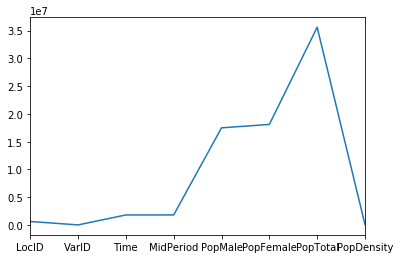

In [17]:
ds.T.plot()

## A Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected poeple. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

Now we willselect USA with a clear exponential curve  and build a linear regression model to predict the log of the number of case and test how well the model fits the data. 

Then,we will select the data from China which would  show some divergence from the model since they have managed to slow the growth of cases. 


In [18]:
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)
covid.head(10)

Province/State       Country/Region      Lat      Long  \
0                           NaN          Afghanistan  33.0000   65.0000   
1                           NaN              Albania  41.1533   20.1683   
2                           NaN              Algeria  28.0339    1.6596   
3                           NaN              Andorra  42.5063    1.5218   
4                           NaN               Angola -11.2027   17.8739   
5                           NaN  Antigua and Barbuda  17.0608  -61.7964   
6                           NaN            Argentina -38.4161  -63.6167   
7                           NaN              Armenia  40.0691   45.0382   
8  Australian Capital Territory            Australia -35.4735  149.0124   
9               New South Wales            Australia -33.8688  151.2093   

   1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  5/14/20  \
0        0        0        0        0        0        0  ...     5639   
1        0        0        0        0        0        0  ...      898   
2        0        0        0        0        0        0  ...     6442   
3        0        0        0        0        0        0  ...      761   
4        0        0        0        0        0        0  ...       48   
5        0        0        0        0        0        0  ...       25   
6        0        0        0        0        0        0  ...     7134   
7        0        0        0        0        0        0  ...     3860   
8        0        0        0        0        0        0  ...      107   
9        0        0        0        0        3        4  ...     3071   

   5/15/20  5/16/20  5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  \
0     6053     6402     6664     7072     7653     8145     8676     9216   
1      916      933      946      948      949      964      969      981   
2     6629     6821     7019     7201     7377     7542     7728     7918   
3      761      761      761      761      761      762      762      762   
4       48       48       48       50       52       52       58       60   
5       25       25       25       25       25       25       25       25   
6     7479     7805     8068     8371     8809     9283     9931    10649   
7     4044     4283     4472     4823     5041     5271     5606     5928   
8      107      107      107      107      107      107      107      107   
9     3074     3075     3076     3078     3081     3082     3084     3086   

   5/23/20  
0     9998  
1      989  
2     8113  
3      762  
4       61  
5       25  
6    11353  
7     6302  
8      107  
9     3087  

[10 rows x 127 columns]

In [19]:
covid= covid.drop(columns=['Province/State', 'Lat', 'Long'], axis=1)
covid.head()

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0    Afghanistan        0        0        0        0        0        0   
1        Albania        0        0        0        0        0        0   
2        Algeria        0        0        0        0        0        0   
3        Andorra        0        0        0        0        0        0   
4         Angola        0        0        0        0        0        0   

   1/28/20  1/29/20  1/30/20  ...  5/14/20  5/15/20  5/16/20  5/17/20  \
0        0        0        0  ...     5639     6053     6402     6664   
1        0        0        0  ...      898      916      933      946   
2        0        0        0  ...     6442     6629     6821     7019   
3        0        0        0  ...      761      761      761      761   
4        0        0        0  ...       48       48       48       48   

   5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  
0     7072     7653     8145     8676     9216     9998  
1      948      949      964      969      981      989  
2     7201     7377     7542     7728     7918     8113  
3      761      761      762      762      762      762  
4       50       52       52       58       60       61  

[5 rows x 124 columns]

In [20]:
covidd = covid.groupby('Country/Region').sum()
covidd.head()

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  ...  5/14/20  5/15/20  5/16/20  \
Country/Region                             ...                              
Afghanistan           0        0        0  ...     5639     6053     6402   
Albania               0        0        0  ...      898      916      933   
Algeria               0        0        0  ...     6442     6629     6821   
Andorra               0        0        0  ...      761      761      761   
Angola                0        0        0  ...       48       48       48   

                5/17/20  5/18/20  5/19/20  5/20/20  5/21/20  5/22/20  5/23/20  
Country/Region                                                                 
Afghanistan        6664     7072     7653     8145     8676     9216     9998  
Albania             946      948      949      964      969      981      989  
Algeria            7019     7201     7377     7542     7728     7918     8113  
Andorra             761      761      761      762      762      762      762  
Angola               48       50       52       52       58       60       61  

[5 rows x 123 columns]

In [30]:
america=covidd.loc[['US']].T

america.index.names = ['date']
america.head()

Country/Region  US
date              
1/22/20          1
1/23/20          1
1/24/20          2
1/25/20          2
1/26/20          5

In [31]:
import datetime
america.index = pd.to_datetime(america.index)
america.index.dtype
america

Country/Region       US
date                   
2020-01-22            1
2020-01-23            1
2020-01-24            2
2020-01-25            2
2020-01-26            5
...                 ...
2020-05-19      1528568
2020-05-20      1551853
2020-05-21      1577147
2020-05-22      1600937
2020-05-23      1622612

[123 rows x 1 columns]

In [32]:
list(grouped.loc['US'])

[1,
 1,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 7,
 8,
 8,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 15,
 15,
 15,
 51,
 51,
 57,
 58,
 60,
 68,
 74,
 98,
 118,
 149,
 219,
 267,
 403,
 519,
 588,
 962,
 1285,
 1667,
 2181,
 2729,
 3536,
 4661,
 6437,
 7781,
 13748,
 19274,
 25600,
 33280,
 43862,
 53925,
 65844,
 83836,
 101962,
 121786,
 140910,
 162147,
 188172,
 213602,
 244008,
 275798,
 309027,
 336802,
 366317,
 397121,
 428654,
 463327,
 496846,
 526776,
 555313,
 580624,
 607670,
 636674,
 667981,
 700062,
 732590,
 758809,
 784708,
 811865,
 840351,
 869170,
 905358,
 938154,
 965785,
 988197,
 1012582,
 1039909,
 1069424,
 1103461,
 1132539,
 1158040,
 1180375,
 1204351,
 1229331,
 1257023,
 1283929,
 1309550,
 1329260,
 1347881,
 1369376,
 1390406,
 1417774,
 1442824,
 1467820,
 1486757,
 1508308,
 1528568,
 1551853,
 1577147,
 1600937,
 1622612]

In [33]:
date_list=['1/22/20',	 '1/23/20',	 '1/24/20',	 '1/25/20',	 '1/26/20',	 '1/27/20',	 '1/28/20',	 '1/29/20',	 '1/30/20',	 '1/31/20',	 '2/1/20',	 '2/2/20',	 '2/3/20',	 '2/4/20',	 '2/5/20',	 '2/6/20',	 '2/7/20',	 '2/8/20',	 '2/9/20',	 '2/10/20',	 '2/11/20',	 '2/12/20',	 '2/13/20',	 '2/14/20',	 '2/15/20',	 '2/16/20',	 '2/17/20',	 '2/18/20',	 '2/19/20',	 '2/20/20',	 '2/21/20',	 '2/22/20',	 '2/23/20',	 '2/24/20',	 '2/25/20',	 '2/26/20',	 '2/27/20',	 '2/28/20',	 '2/29/20',	 '3/1/20',	 '3/2/20',	 '3/3/20',	 '3/4/20',	 '3/5/20',	 '3/6/20',	 '3/7/20',	 '3/8/20',	 '3/9/20',	 '3/10/20',	 '3/11/20',	 '3/12/20',	 '3/13/20',	 '3/14/20',	 '3/15/20',	 '3/16/20',	 '3/17/20',	 '3/18/20',	 '3/19/20',	 '3/20/20',	 '3/21/20',	 '3/22/20',	 '3/23/20',	 '3/24/20',	 '3/25/20',	 '3/26/20',	 '3/27/20',	 '3/28/20',	 '3/29/20',	 '3/30/20',	 '3/31/20',	 '4/1/20',	 '4/2/20',	 '4/3/20',	 '4/4/20',	 '4/5/20',	 '4/6/20',	 '4/7/20',	 '4/8/20',	 '4/9/20',	 '4/10/20',	 '4/11/20',	 '4/12/20',	 '4/13/20',	 '4/14/20',	 '4/15/20',	 '4/16/20',	 '4/17/20',	 '4/18/20',	 '4/19/20',	 '4/20/20',	 '4/21/20',	 '4/22/20',	 '4/23/20',	 '4/24/20',	 '4/25/20',	 '4/26/20',	 '4/27/20',	 '4/28/20',	 '4/29/20',	 '4/30/20',	 '5/1/20',	 '5/2/20',	 '5/3/20',	 '5/4/20',	 '5/5/20',	 '5/6/20',	 '5/7/20',	 '5/8/20',	 '5/9/20',	 '5/10/20',	 '5/11/20',	 '5/12/20',	 '5/13/20',	 '5/14/20',	 '5/15/20',	 '5/16/20',	 '5/17/20',	 '5/18/20',	 '5/19/20',	 '5/20/20',	 '5/21/20',	 '5/22/20',	 '5/23/20'
]
case_list=[1,	 1,	 2,	 2,	 5,	 5,	 5,	 5,	 5,	 7,	 8,	 8,	 11,	 11,	 11,	 11,	 11,	 11,	 11,	 11,	 12,	 12,	 13,	 13,	 13,	 13,	 13,	 13,	 13,	 13,	 15,	 15,	 15,	 51,	 51,	 57,	 58,	 60,	 68,	 74,	 98,	 118,	 149,	 219,	 267,	 403,	 519,	 588,	 962,	 1285,	 1667,	 2181,	 2729,	 3536,	 4661,	 6437,	 7781,	 13748,	 19274,	 25600,	 33280,	 43862,	 53925,	 65844,	 83836,	 101962,	 121786,	 140910,	 162147,	 188172,	 213602,	 244008,	 275798,	 309027,	 336802,	 366317,	 397121,	 428654,	 463327,	 496846,	 526776,	 555313,	 580624,	 607670,	 636674,	 667981,	 700062,	 732590,	 758809,	 784708,	 811865,	 840351,	 869170,	 905358,	 938154,	 965785,	 988197,	 1012582,	 1039909,	 1069424,	 1103461,	 1132539,	 1158040,	 1180375,	 1204351,	 1229331,	 1257023,	 1283929,	 1309550,	 1329260,	 1347881,	 1369376,	 1390406,	 1417774,	 1442824,	 1467820,	 1486757,	 1508308,	 1528568,	 1551853,	 1577147,	 1600937,	1622612
]

In [34]:

total = pd.DataFrame(data=np.transpose(np.array([np.arange(0, 123),case_list])), index=date_list, columns=['Days', 'Cases'])
total.index.name='Date'
total

Days    Cases
Date                  
1/22/20     0        1
1/23/20     1        1
1/24/20     2        2
1/25/20     3        2
1/26/20     4        5
...       ...      ...
5/19/20   118  1528568
5/20/20   119  1551853
5/21/20   120  1577147
5/22/20   121  1600937
5/23/20   122  1622612

[123 rows x 2 columns]

In [35]:

total['log(Cases)'] = total['Cases'].apply(np.log10)
total

Days    Cases  log(Cases)
Date                              
1/22/20     0        1    0.000000
1/23/20     1        1    0.000000
1/24/20     2        2    0.301030
1/25/20     3        2    0.301030
1/26/20     4        5    0.698970
...       ...      ...         ...
5/19/20   118  1528568    6.184285
5/20/20   119  1551853    6.190851
5/21/20   120  1577147    6.197872
5/22/20   121  1600937    6.204374
5/23/20   122  1622612    6.210215

[123 rows x 3 columns]

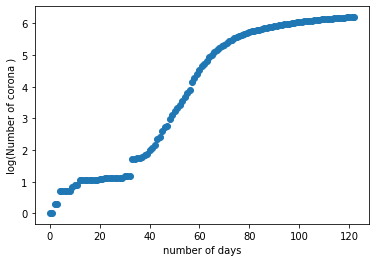

In [36]:
plt.scatter(total['Days'], total['log(Cases)'])
plt.xlabel('number of days')
plt.ylabel('log(Number of corona )')
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# For X_train, we take nature number start from 0 to represent the dates
# Your code here
X_train = np.arange(len(dates)).reshape(-1, 1)

# For y_train, we take the number of confirmed cases globally
# Your code here
y_train = covid[dates].sum()

# Transform our data for polynomial regression
# Your code here
poly = PolynomialFeatures(degree = 4)
X_train_poly = poly.fit_transform(X_train)

# Train model with the data
# Your code here
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# For forecasting and visualizing, we create X_test which is X_train + 10 more days
# Your code here
X_test = np.arange(len(dates) + 10).reshape(-1, 1)
X_test_poly = poly.transform(X_test)

# Transform with PolynomialFeatures to have the same shape with X_train_poly
# Your code here

# Forecasting
predictions = linear_model.predict(X_test_poly)

In [44]:
model_total =total[total['Days']>5]
X = model_total[['Days']]
y = model_total['log(Cases)']
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train ,y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape,X_test.shape)

model = LinearRegression()
model.fit(X_train,y_train)

(93, 1) (24, 1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predicted = model.predict(X_test)

print("MSE:",mean_squared_error(y_test,predicted))
print("R^2:",r2_score(y_test,predicted))

MSE: 0.28849976302568037
R^2: 0.9338477929163148


In [46]:
dates = covid.columns[4:]
dates

Index(['1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20',
       '1/31/20', '2/1/20', '2/2/20', '2/3/20',
       ...
       '5/14/20', '5/15/20', '5/16/20', '5/17/20', '5/18/20', '5/19/20',
       '5/20/20', '5/21/20', '5/22/20', '5/23/20'],
      dtype='object', length=120)

In [47]:
covid[dates].sum().diff()

1/25/20         NaN
1/26/20       684.0
1/27/20       809.0
1/28/20      2651.0
1/29/20       588.0
             ...   
5/19/20     95549.0
5/20/20     98980.0
5/21/20    105952.0
5/22/20    108393.0
5/23/20     99545.0
Length: 120, dtype: float64

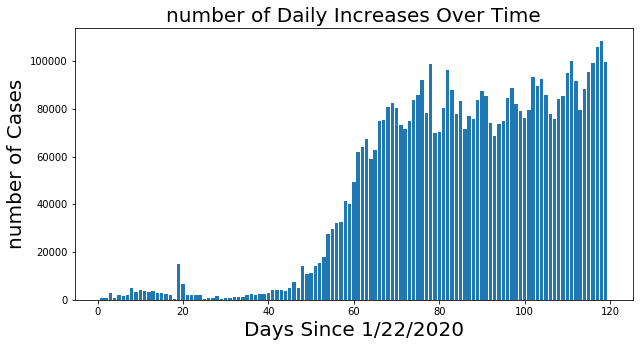

In [48]:
USA_daily_increases = covid[dates].sum().diff()

plt.figure(figsize=(10, 5))
plt.bar(range(len(USA_daily_increases)), USA_daily_increases)
plt.title('number of Daily Increases Over Time', size=20)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('number of Cases', size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [49]:
China=covidd.loc[['China']].T

China.index.names = ['date']
China.head()

Country/Region  China
date                 
1/22/20           548
1/23/20           643
1/24/20           920
1/25/20          1406
1/26/20          2075

In [50]:
import datetime
China.index = pd.to_datetime(China.index)
China.index.dtype
China

Country/Region  China
date                 
2020-01-22        548
2020-01-23        643
2020-01-24        920
2020-01-25       1406
2020-01-26       2075
...               ...
2020-05-19      84063
2020-05-20      84063
2020-05-21      84063
2020-05-22      84081
2020-05-23      84084

[123 rows x 1 columns]

In [51]:
date_list = ['1/22/20', '1/23/20','1/24/20','1/25/20','1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20','2/1/20','2/2/20','2/3/20', '2/4/20', '2/5/20', '2/6/20','2/7/20',	 '2/8/20',	 '2/9/20',	 '2/10/20',	 '2/11/20',	 '2/12/20',	 '2/13/20',	 '2/14/20',	 '2/15/20',	 '2/16/20',	 '2/17/20',	 '2/18/20',	 '2/19/20',	 '2/20/20',	 '2/21/20',	 '2/22/20',	 '2/23/20',	 '2/24/20',	 '2/25/20',	 '2/26/20',	 '2/27/20',	 '2/28/20',	 '2/29/20',	 '3/1/20',	 '3/2/20',	 '3/3/20',	 '3/4/20',	 '3/5/20',	 '3/6/20',	 '3/7/20',	 '3/8/20',	 '3/9/20',	 '3/10/20',	 '3/11/20',	 '3/12/20',	 '3/13/20',	 '3/14/20',	 '3/15/20',	 '3/16/20',	 '3/17/20',	 '3/18/20',	 '3/19/20',	 '3/20/20',	 '3/21/20',	 '3/22/20',	 '3/23/20',	 '3/24/20',	 '3/25/20',	 '3/26/20',	 '3/27/20',	 '3/28/20',	 '3/29/20',	 '3/30/20',	 '3/31/20',	 '4/1/20',	 '4/2/20',	 '4/3/20',	 '4/4/20',	 '4/5/20',	 '4/6/20',	 '4/7/20',	 '4/8/20',	 '4/9/20',	 '4/10/20',	 '4/11/20',	 '4/12/20',	 '4/13/20',	 '4/14/20',	 '4/15/20',	 '4/16/20',	 '4/17/20',	 '4/18/20',	 '4/19/20',	 '4/20/20',	 '4/21/20',	 '4/22/20',	 '4/23/20',	 '4/24/20',	 '4/25/20',	 '4/26/20',	 '4/27/20',	 '4/28/20',	 '4/29/20',	 '4/30/20',	 '5/1/20',	 '5/2/20',	 '5/3/20',	 '5/4/20',	 '5/5/20',	 '5/6/20',	 '5/7/20',	 '5/8/20',	 '5/9/20',	 '5/10/20',	 '5/11/20',	 '5/12/20',	 '5/13/20',	 '5/14/20',	 '5/15/20',	 '5/16/20',	 '5/17/20',	 '5/18/20',	 '5/19/20',	 '5/20/20',	 '5/21/20',	 '5/22/20'
]
case_list=[548, 643,	 920,	 1406,	 2075,	 2877,	 5509,	 6087,	 8141,	 9802,	 11891,	 16630,	 19716,	 23707,	 27440,	 30587,	 34110,	 36814,	 39829,	 42354,	 44386,	 44759,	 59895,	 66358,	 68413,	 70513,	 72434,	 74211,	 74619,	 75077,	 75550,	 77001,	 77022,	 77241,	 77754,	 78166,	 78600,	 78928,	 79356,	 79932,	 80136,	 80261,	 80386,	 80537,	 80690,	 80770,	 80823,	 80860,	 80887,	 80921,	 80932,	 80945,	 80977,	 81003,	 81033,	 81058,	 81102,	 81156,	 81250,	 81305,	 81435,	 81498,	 81591,	 81661,	 81782,	 81897,	 81999,	 82122,	 82198,	 82279,	 82361,	 82432,	 82511,	 82543,	 82602,	 82665,	 82718,	 82809,	 82883,	 82941,	 83014,	 83134,	 83213,	 83306,	 83356,	 83403,	 83760,	 83787,	 83805,	 83817,	 83853,	 83868,	 83884,	 83899,	 83909,	 83912,	 83918,	 83940,	 83944,	 83956,	 83959,	 83959,	 83964,	 83966,	 83968,	 83970,	 83975,	 83976,	 83990,	 84010,	 84011,	 84018,	 84024,	 84029,	 84038,	 84044,	 84054,	 84063,	 84063,	 84063,	 84063,	84081]


In [52]:

total2 = pd.DataFrame(data=np.transpose(np.array([np.arange(0, 122),case_list])), index=date_list, columns=['Days', 'Cases'])
total2.index.name='Date'
total2

Days  Cases
Date                
1/22/20     0    548
1/23/20     1    643
1/24/20     2    920
1/25/20     3   1406
1/26/20     4   2075
...       ...    ...
5/18/20   117  84063
5/19/20   118  84063
5/20/20   119  84063
5/21/20   120  84063
5/22/20   121  84081

[122 rows x 2 columns]

In [53]:

total2['log(Cases)'] = total2['Cases'].apply(np.log10)
total2

Days  Cases  log(Cases)
Date                            
1/22/20     0    548    2.738781
1/23/20     1    643    2.808211
1/24/20     2    920    2.963788
1/25/20     3   1406    3.147985
1/26/20     4   2075    3.317018
...       ...    ...         ...
5/18/20   117  84063    4.924605
5/19/20   118  84063    4.924605
5/20/20   119  84063    4.924605
5/21/20   120  84063    4.924605
5/22/20   121  84081    4.924698

[122 rows x 3 columns]

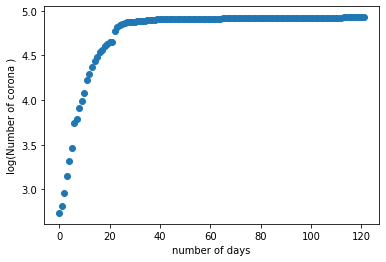

In [54]:
plt.scatter(total2['Days'], total2['log(Cases)'])
plt.xlabel('number of days')
plt.ylabel('log(Number of corona )')
plt.show()

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# For X_train, we take nature number start from 0 to represent the dates
# Your code here
X_train = np.arange(len(dates)).reshape(-1, 1)

# For y_train, we take the number of confirmed cases globally
# Your code here
y_train = covid[dates].sum()

# Transform our data for polynomial regression
# Your code here
poly = PolynomialFeatures(degree = 4)
X_train_poly = poly.fit_transform(X_train)

# Train model with the data
# Your code here
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# For forecasting and visualizing, we create X_test which is X_train + 10 more days
# Your code here
X_test = np.arange(len(dates) + 10).reshape(-1, 1)
X_test_poly = poly.transform(X_test)

# Transform with PolynomialFeatures to have the same shape with X_train_poly
# Your code here

# Forecasting
predictions = linear_model.predict(X_test_poly)

In [56]:
model_total2 =total2[total['Days']>5]
X = model_total2[['Days']]
y = model_total2['log(Cases)']
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train ,y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape,X_test.shape)

model = LinearRegression()
model.fit(X_train,y_train)

(92, 1) (24, 1)


C:\Users\rakshith\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predicted = model.predict(X_test)

print("MSE:",mean_squared_error(y_test,predicted))
print("R^2:",r2_score(y_test,predicted))

MSE: 0.0487654176125255
R^2: 0.33144979193356305


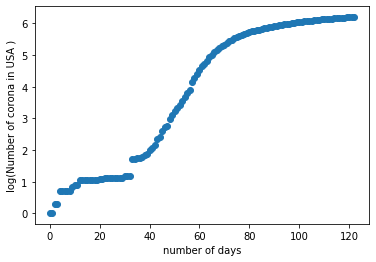

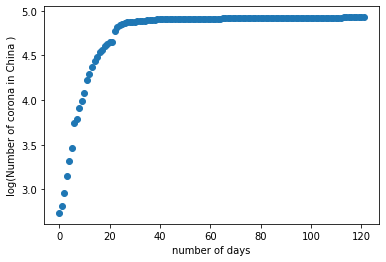

In [58]:
#CONCLUSION
plt.scatter(total['Days'], total['log(Cases)'])
plt.xlabel('number of days')
plt.ylabel('log(Number of corona in USA )')
plt.show()
plt.scatter(total2['Days'], total2['log(Cases)'])
plt.xlabel('number of days')
plt.ylabel('log(Number of corona in China )')
plt.show()

From the above two graphs we can say that China has prevented the spread of the virus as we can see the cure straightens whereas in USA the graph is on the raise


China:
    MSE: MSE: 0.0487654176125255
            
R^2: 0.33144979193356305

USA:

    MSE: MSE: 0.28849976302568037
            
R^2: 0.9338477929163148
    AS the MSE scores is less the model prediction is validated
    